In [26]:
%load_ext autoreload
%autoreload 2
import tqdm
import numpy as np
import pandas as pd

import torch
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader

from data import load_test_data, generate_training_samples
from dataset import STDataset
from evaluate import Evaluator
from utils import *

from parameter import create_args
from models.common import get_linear_scheduler
from models.vae_gaussian import GaussianVAE
from models.vae_flow import FlowVAE
from models.ddpm import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
training_samples = generate_training_samples(num_samples_per_slice=10)
all_test_items = load_test_data(num_holes=10)

Seeding all randomness with seed=2024
Seeding all randomness with seed=2024
Donor_id: MsBrainAgingSpatialDonor_1
Slice_id: 0
Donor_id: MsBrainAgingSpatialDonor_2
Slice_id: 0
Slice_id: 1
Donor_id: MsBrainAgingSpatialDonor_3
Slice_id: 0
Slice_id: 1
Donor_id: MsBrainAgingSpatialDonor_4
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_5
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_6
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_7
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_8
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_9
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_10
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_11
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_12
Slice_id: 0
Slice_id: 1


In [3]:
tissue_distribution = count_dominant_tissue(training_samples)
print(tissue_distribution)

{'striatum': 125, 'cortical layer VI': 67, 'cortical layer V': 36, 'corpus callosum': 42, 'cortical layer II/III': 34, 'pia mater': 6}


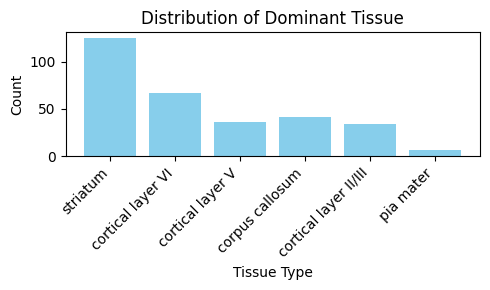

In [4]:
plot_tissue_distribution(tissue_distribution)

In [15]:
# filter_training_samples = filter_training_sample_by_tissue(training_samples, tissue_name="striatum")
# len(filter_training_samples)

In [5]:
tissue_index = {
    'striatum': 0,
    'cortical layer VI': 1,
    'cortical layer V': 2,
    'corpus callosum': 3,
    'cortical layer II/III': 4,
    'pia mater': 5
}


In [6]:
dataset = STDataset(training_samples)
# dataset = STDataset(filter_training_samples)
# Define a DataLoader to handle batching
# dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=4)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [10]:
args = create_args()

In [11]:
if args.model == 'gaussian':
    model = GaussianVAE(args).to(args.device)
elif args.model == 'flow':
    model = FlowVAE(args).to(args.device)

In [12]:
total_params = sum(p.numel() for p in model.parameters())
print("Total number of paramete|rs: ", total_params)

Total number of paramete|rs:  515416


In [36]:
sample = training_samples[1] 
positions = torch.tensor(sample['normalized_positions']).unsqueeze(0).to(model.args.device)  # (1, N, d)
# ani = visualize_noising_process_animation(model, positions, num_steps=100)

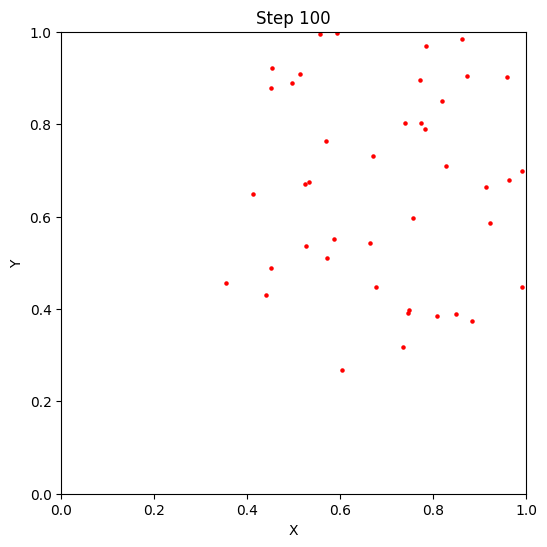

In [42]:
ani = visualize_noising_process_animation(model, positions[0].cpu().numpy())

In [43]:
# Save the animation as a GIF
ani.save("./noising_process_animation.gif", writer='imagemagick', fps=10)

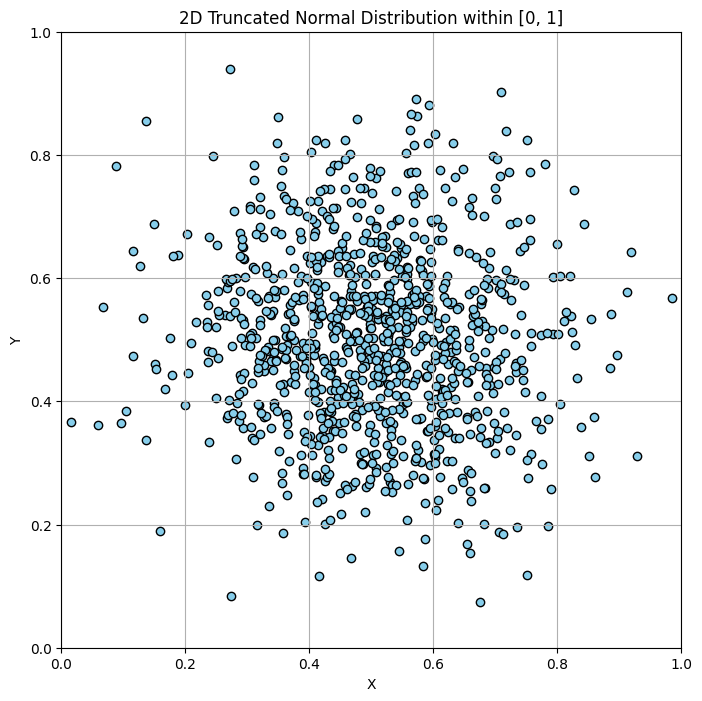

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

def truncated_normal_2d(size, mean=0.5, std=0.15, lower=0.0, upper=1.0):
    """Generate 2D truncated normal distribution data within [lower, upper]."""
    a, b = (lower - mean) / std, (upper - mean) / std
    x = truncnorm.rvs(a, b, loc=mean, scale=std, size=size)
    y = truncnorm.rvs(a, b, loc=mean, scale=std, size=size)
    return np.column_stack((x, y))

# Generate 2D sample data using truncated normal distribution
size = 1000
data_2d = truncated_normal_2d(size, mean=0.5, std=0.15, lower=0.0, upper=1.0)

# Plot the 2D points to visualize the distribution
plt.figure(figsize=(8, 8))
plt.scatter(data_2d[:, 0], data_2d[:, 1], color='skyblue', edgecolor='black')
plt.title('2D Truncated Normal Distribution within [0, 1]')
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [10]:
# Optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), 
    lr=args.lr, 
    weight_decay=args.weight_decay
)

scheduler = get_linear_scheduler(
    optimizer,
    start_epoch=args.sched_start_epoch,
    end_epoch=args.sched_end_epoch,
    start_lr=args.lr,
    end_lr=args.end_lr
)

In [120]:
for epoch in range(args.train_epochs):
    for batch in dataloader:
        positions = batch['positions'].to(args.device)
        expressions = batch['expressions'].to(args.device)
        metadata = batch['metadata']
        
        # Convert tissue types to integers and move to device
        tissue_labels = torch.tensor([tissue_index[tissue] for tissue in metadata['dominant_tissue']], device=args.device)
        
        # Reset grad and model state
        optimizer.zero_grad()
        model.train()
        
        # Step 1: 训练position的扩散模型
        position_loss = model.get_position_loss(positions, tissue_labels)
        position_loss.backward()
        orig_grad_norm = clip_grad_norm_(model.parameters(), args.max_grad_norm)
        optimizer.step()
        scheduler.step()

        # Step 2: 使用训练好的位置模型生成预测位置
        predicted_positions = model.sample_positions(
            z=torch.randn(positions.size(0), model.args.latent_dim).to(args.device), 
            tissue_labels=tissue_labels, 
            num_points=positions.size(1)
        )
        
        # Reset grad for expression model
        optimizer.zero_grad()

        # Step 3: 训练expression的扩散模型
        expression_loss = model.get_expression_loss(predicted_positions, positions, expressions, tissue_labels)
        expression_loss.backward()
        orig_grad_norm = clip_grad_norm_(model.parameters(), args.max_grad_norm)
        optimizer.step()
        scheduler.step()

    print(f"Epoch {epoch}: Position Loss = {position_loss.item()}, Expression Loss = {expression_loss.item()}")


Epoch 0: Position Loss = 35.06364440917969, Expression Loss = 1.0880687236785889
Epoch 1: Position Loss = 22.366708755493164, Expression Loss = 1.096125841140747
Epoch 2: Position Loss = 15.18949031829834, Expression Loss = 1.0764161348342896
Epoch 3: Position Loss = 9.157011032104492, Expression Loss = 1.0150779485702515
Epoch 4: Position Loss = 5.907520294189453, Expression Loss = 0.7536658048629761
Epoch 5: Position Loss = 3.928079128265381, Expression Loss = 1.2402087450027466
Epoch 6: Position Loss = 2.741241455078125, Expression Loss = 0.9802953004837036
Epoch 7: Position Loss = 2.592088222503662, Expression Loss = 0.9847856163978577
Epoch 8: Position Loss = 2.7389707565307617, Expression Loss = 1.2363406419754028
Epoch 9: Position Loss = 1.375482439994812, Expression Loss = 1.0519534349441528
Epoch 10: Position Loss = 1.882859468460083, Expression Loss = 1.0299485921859741
Epoch 11: Position Loss = 1.5703823566436768, Expression Loss = 1.0428380966186523
Epoch 12: Position Loss 

In [127]:
# Initialize dictionaries to store metrics for both baselines
metrics = {
    'Diffusion': {
        'mse': [],
        'f1': [],
        'cosine_sim': [],
        'chamfer_dist': [],
        'emd': []
    }
}

for i, test_item in enumerate(all_test_items):
    print(f"Test Area {i+1}:")
    print(f"  Dominant Tissue: {test_item.test_area.dominant_tissue}")
    print(f"  Number of cells in ground truth: {len(test_item.ground_truth.hole_cells)}")
    
    # Evaluate the predicted results
    true_coords = test_item.ground_truth.hole_cells[['center_x', 'center_y']].values
    true_gene_expressions = test_item.ground_truth.gene_expression
    
    with torch.no_grad():
        z = torch.randn([1, args.latent_dim]).to(args.device)
        tissue_labels = torch.tensor([tissue_index[test_item.test_area.dominant_tissue]], device=args.device)
        
        # Step 1: Sample positions using the model
        pred_coords = model.sample_positions(
            z=z, 
            tissue_labels=tissue_labels, 
            num_points=50
        )
        
        # Step 2: Sample gene expressions based on the predicted positions
        pred_gene_expressions = model.sample_expressions(
            predicted_positions=pred_coords, 
            tissue_labels=tissue_labels
        )
        
        # Convert predicted positions and gene expressions to numpy arrays for evaluation
        pred_coords = pred_coords[0].cpu().numpy()
        pred_gene_expressions = pred_gene_expressions[0].cpu().numpy()

        # Map the predicted positions back to the original coordinate system
        pred_coords = model.map_position_back(pred_coords, test_item.test_area)

    mse_d, f1_d, cosine_sim_d = Evaluator.evaluate_expression(true_coords, true_gene_expressions, pred_coords, pred_gene_expressions)
    chamfer_dist_d = Evaluator.chamfer_distance(true_coords, pred_coords)
    emd_d = Evaluator.calculate_emd(true_coords, pred_coords)
    
    # Collect results for Diffusion method
    metrics['Diffusion']['mse'].append(mse_d)
    metrics['Diffusion']['f1'].append(f1_d)
    metrics['Diffusion']['cosine_sim'].append(cosine_sim_d)
    metrics['Diffusion']['chamfer_dist'].append(chamfer_dist_d)
    metrics['Diffusion']['emd'].append(emd_d)
    
    # Visualize the true and predicted coordinates (optional)
    # visualize_coords(true_coords, pred_coords)
    # break  # Uncomment this if you only want to run the first test item


Test Area 1:
  Dominant Tissue: striatum
  Number of cells in ground truth: 50
Test Area 2:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 3:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 4:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 5:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 6:
  Dominant Tissue: striatum
  Number of cells in ground truth: 50
Test Area 7:
  Dominant Tissue: striatum
  Number of cells in ground truth: 50
Test Area 8:
  Dominant Tissue: striatum
  Number of cells in ground truth: 50
Test Area 9:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 10:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 11:
  Dominant Tissue: striatum
  Number of cells in ground truth: 50
Test Area 12:
  Dominant Tissue: corpus callosum
  Number of cells in groun

In [128]:
for method in metrics:
    print(f"Results for {method}:")
    for metric in metrics[method]:
        mean_value = np.mean(metrics[method][metric])
        std_value = np.std(metrics[method][metric])
        print(f"  {metric.capitalize()}: Mean = {mean_value:.4f}, Std = {std_value:.4f}")

Results for Diffusion:
  Mse: Mean = 1.4254, Std = 0.1991
  F1: Mean = 0.8267, Std = 0.0621
  Cosine_sim: Mean = 0.0223, Std = 0.0234
  Chamfer_dist: Mean = 31.4086, Std = 4.2803
  Emd: Mean = 32.6028, Std = 6.9186
